In [50]:
import os, sys
sys.path.append(os.path.join(os.path.dirname("/data/chenghao/private/coloradar/core")))

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from core.radar import SCRadar, CCRadar
from core.dataset import Coloradar
from core.utils import radardsp as rdsp


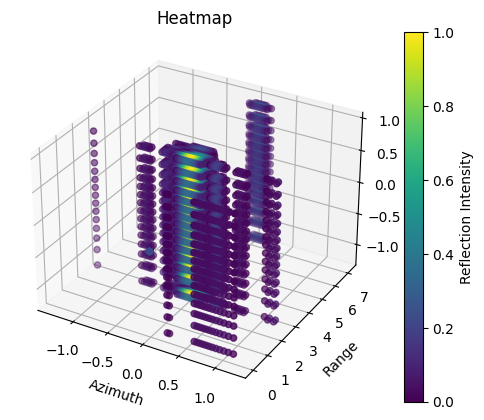

In [51]:
# 注册API接口
coloradar = Coloradar()
record = coloradar.getRecord("outdoor0", 0) 
record.load("scradar") # 加载radar数据集，这里以单芯片radar方案为例

# 获取实例对象
scradar_ = record.scradar
# scradar_.show() # 可视化点云
scradar_.showHeatmap()
# scradar_.showHeatmapBirdEyeView(threshold=0.1)

In [52]:
'''
下面梳理如何从ADC数据一步步得到点云数据
'''

''' 
第一步: 获取原始ADC数据
'''
adc_samples = scradar_.raw
# print(adc_samples.shape)

# step1：去除直流偏置
adc_samples -= np.mean(adc_samples)
# print(np.mean(adc_samples))

if scradar_.sensor != "scradar": # scradar数据不进行校准（本示例此处跳过）
    adc_samples *= scradar_.calibration.get_frequency_calibration()
    adc_samples *= scradar_.calibration.get_phase_calibration()

print(adc_samples.shape) # shape size -> (3, 4, 128, 128)

(3, 4, 128, 128)


原始ADC数据维度为： (3, 4, 128, 128)
分别表示3个TX，4个RX，128个chirps，每个chirp采样128samples。

获得ADC数据后，一般流程是对adc数据进行[**加窗处理**](https://zhuanlan.zhihu.com/p/24318554)

常用的窗函数有：



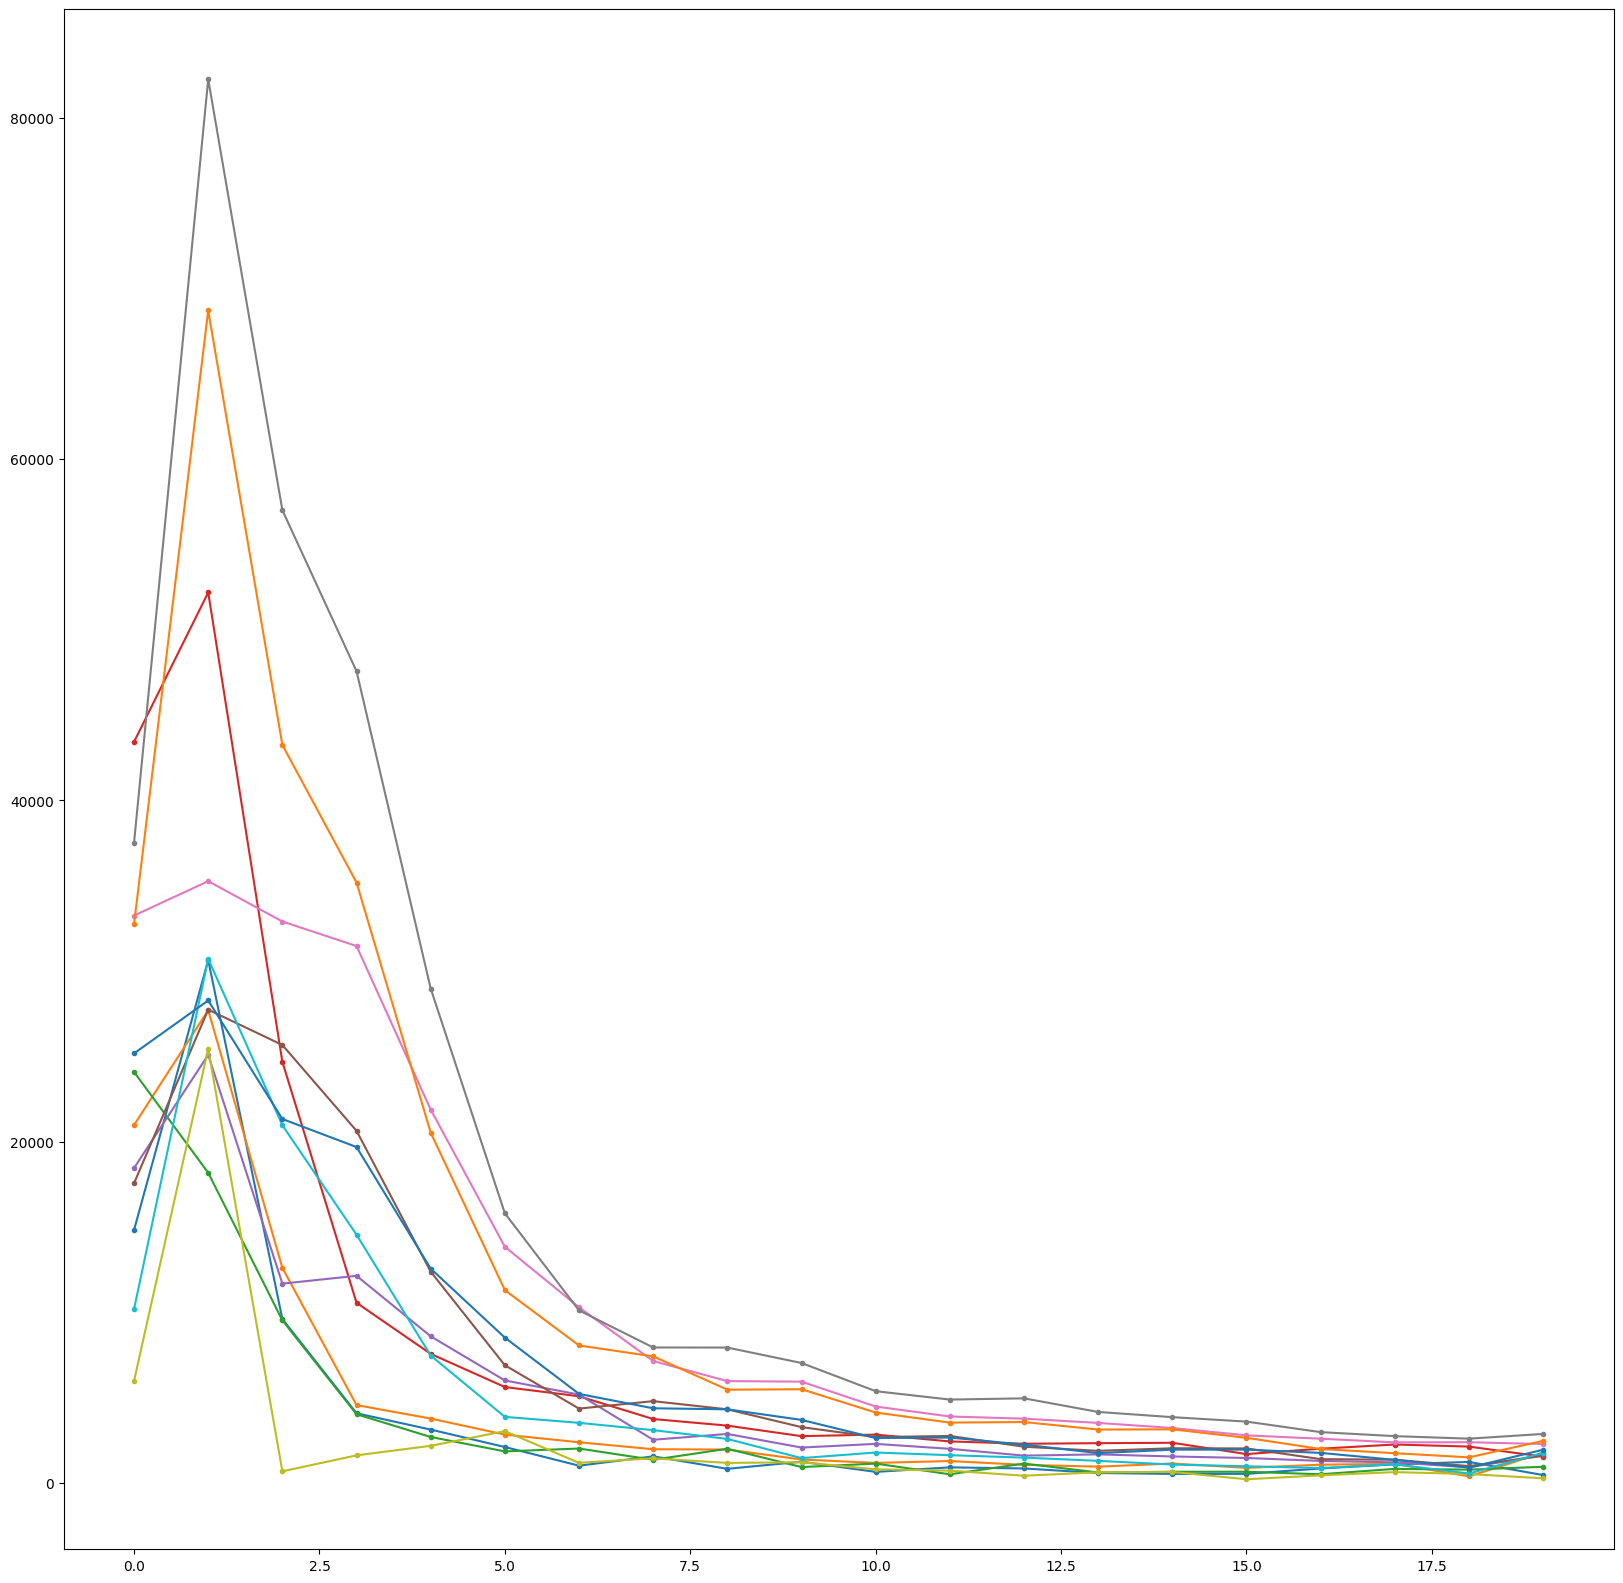

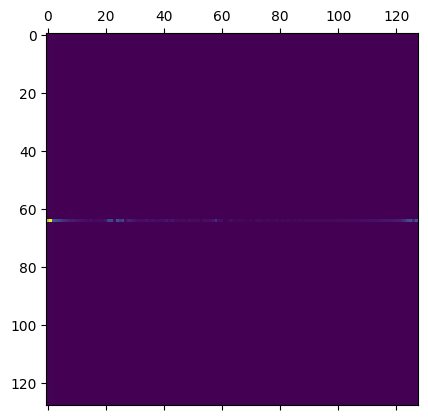

In [63]:

''' 
第二步: FFT处理
'''

ntx, nrx, nc, ns = adc_samples.shape

# Range FFT
samples = adc_samples * np.blackman(ns).reshape(1, 1, 1, -1) # 加窗
rfft = np.fft.fft(adc_samples, ns, -1)
# rfft -= scradar_.calibration.get_coupling_calibration() #

# tmpData = scradar_.calibration.get_coupling_calibration()
# tmpData.reshape([-1])
# plt.figure()
# plt.plot(tmpData.reshape([-1]))

# 可视化rangeFFT结果
plt.figure(figsize=(20,20))
for ntx_i in range(ntx):
    for nrx_i in range(nrx):
            rfft_mod = np.abs(rfft[ntx_i, nrx_i, 0, 0:20])
            # print(rfft_mod.shape)
            plt.plot(rfft_mod,'.-')

# Doppler FFT
dfft = np.fft.fft(rfft, nc, -2)
dfft = np.fft.fftshift(dfft, -2)
vcomp = rdsp.velocity_compensation(ntx, nc) # 速度补偿
dfft *= vcomp

dfft_tmp = dfft[0,0,:,:].reshape([nc, ns])
dfft_mod = np.abs(dfft_tmp)
# print(dfft_tmp.shape, dfft_mod.shape)
plt.matshow(dfft_mod)